YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Buy & Hold return: 421.36%


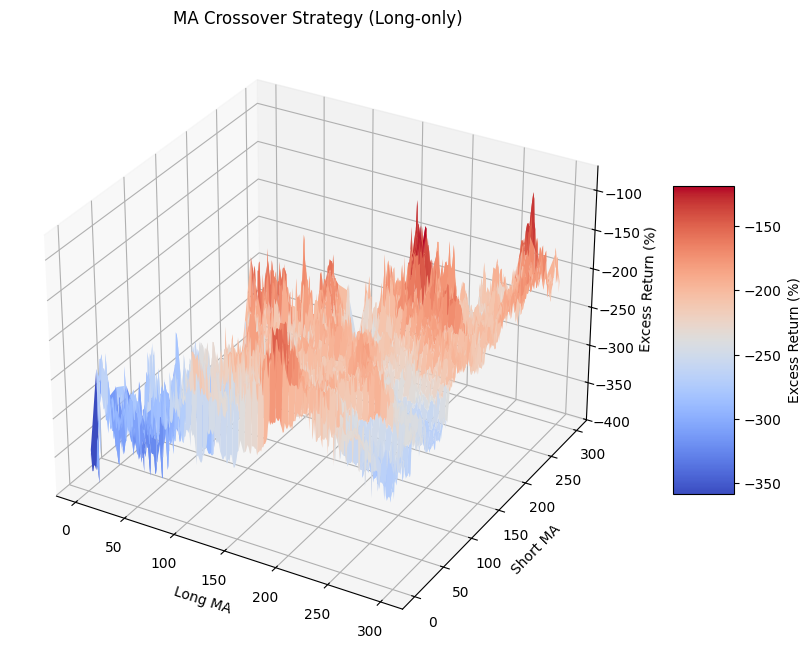

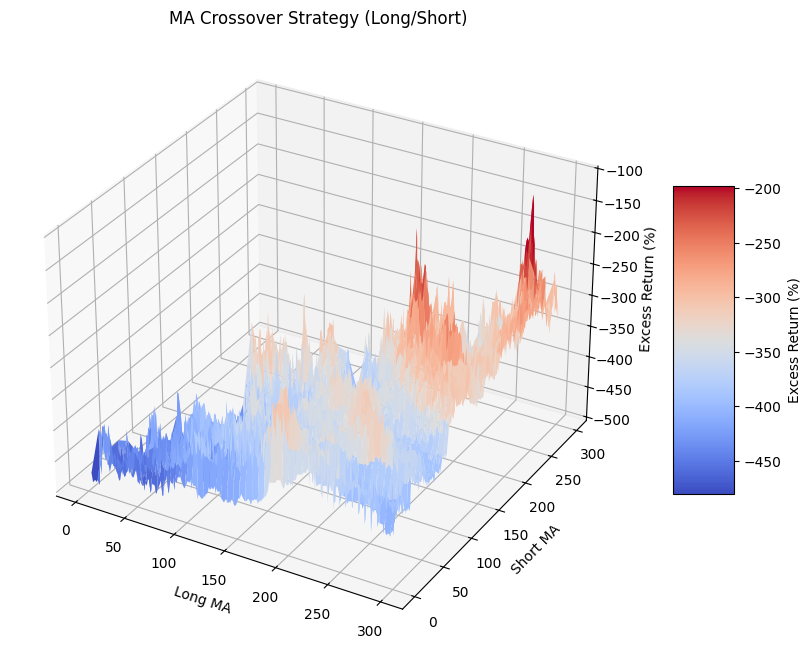

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Download historical data
ticker = "^GSPC"
start_date = "2010-01-01"
end_date = "2024-12-31"
data = yf.download(ticker, start=start_date, end=end_date)
df = data['Close'].copy()

# Reset and clean up the dataframe
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
df = df.reset_index()
df.columns = ['Date', 'Close']
df = df.set_index("Date")

# Step 2: Define MA ranges
short_windows = range(1, 300)
long_windows = range(1, 300)

# Store results for both strategies
results_long_only = []
results_long_short = []

# Step 3: Iterate over combinations
for short in short_windows:
    for long in long_windows:
        if short >= long:
            continue

        temp_df = df.copy()
        temp_df["SMA_short"] = temp_df["Close"].rolling(window=short).mean()
        temp_df["SMA_long"] = temp_df["Close"].rolling(window=long).mean()
        temp_df["returns"] = temp_df["Close"].pct_change()

        # Long-only
        temp_df["signal_long_only"] = 0
        temp_df.loc[temp_df.index[long:], "signal_long_only"] = np.where(
            temp_df["SMA_short"].iloc[long:] > temp_df["SMA_long"].iloc[long:], 1, 0
        )
        temp_df["strategy_long_only"] = temp_df["returns"] * temp_df["signal_long_only"].shift(1)
        cumulative_return_long_only = (temp_df["strategy_long_only"] + 1).prod() - 1
        results_long_only.append((short, long, cumulative_return_long_only * 100))  # in %

        # Long/Short
        temp_df["signal_long_short"] = 0
        temp_df.loc[temp_df.index[long:], "signal_long_short"] = np.where(
            temp_df["SMA_short"].iloc[long:] > temp_df["SMA_long"].iloc[long:], 1, -1
        )
        temp_df["strategy_long_short"] = temp_df["returns"] * temp_df["signal_long_short"].shift(1)
        cumulative_return_long_short = (temp_df["strategy_long_short"] + 1).prod() - 1
        results_long_short.append((short, long, cumulative_return_long_short * 100))  # in %

# Step 4: Buy & Hold
buy_hold_return = (df["Close"].iloc[-1] / df["Close"].iloc[0]) - 1
buy_hold_return_pct = buy_hold_return * 100
print(f"Buy & Hold return: {buy_hold_return_pct:.2f}%")

# Step 5: DataFrames
df_long_only = pd.DataFrame(results_long_only, columns=["short", "long", "return"])
df_long_only["excess_return"] = df_long_only["return"] - buy_hold_return_pct

df_long_short = pd.DataFrame(results_long_short, columns=["short", "long", "return"])
df_long_short["excess_return"] = df_long_short["return"] - buy_hold_return_pct

# Step 6: Pivot for plotting
pivot_long_only = df_long_only.pivot(index="short", columns="long", values="excess_return")
pivot_long_short = df_long_short.pivot(index="short", columns="long", values="excess_return")

# Step 7: 3D plot for Long-only
X1, Y1 = np.meshgrid(pivot_long_only.columns, pivot_long_only.index)
Z1 = pivot_long_only.values

fig1 = plt.figure(figsize=(12, 8))
ax1 = fig1.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(X1, Y1, Z1, cmap="coolwarm", edgecolor="none")
ax1.set_xlabel("Long MA")
ax1.set_ylabel("Short MA")
ax1.set_zlabel("Excess Return (%)")
ax1.set_title("MA Crossover Strategy (Long-only)")
plt.colorbar(surf1, shrink=0.5, aspect=5, label="Excess Return (%)")
plt.show()

# Step 8: 3D plot for Long/Short
X2, Y2 = np.meshgrid(pivot_long_short.columns, pivot_long_short.index)
Z2 = pivot_long_short.values

fig2 = plt.figure(figsize=(12, 8))
ax2 = fig2.add_subplot(111, projection='3d')
surf2 = ax2.plot_surface(X2, Y2, Z2, cmap="coolwarm", edgecolor="none")
ax2.set_xlabel("Long MA")
ax2.set_ylabel("Short MA")
ax2.set_zlabel("Excess Return (%)")
ax2.set_title("MA Crossover Strategy (Long/Short)")
plt.colorbar(surf2, shrink=0.5, aspect=5, label="Excess Return (%)")
plt.show()

